# **Entrega LAB3 IA Generativa - Imágenes**

- Ejercicio 1: Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)

- Ejercicio 2: Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.

Alumnos:
- Lydia Sánchez - Cano Sánchez
- Paloma Moya Tudela
- Sofía Peña González

# **Ejercicio 1**

Importamnos la librería que presenta los datos con los que vamos a trabajar y dividimos nuestros conjuntos de datos.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


Normalizamos nuestros datos de entrenamiento y de test.

In [ ]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

Definimos la función plot_images para creación de la figura, de los ejes y visualización de imágenes y etiquetas

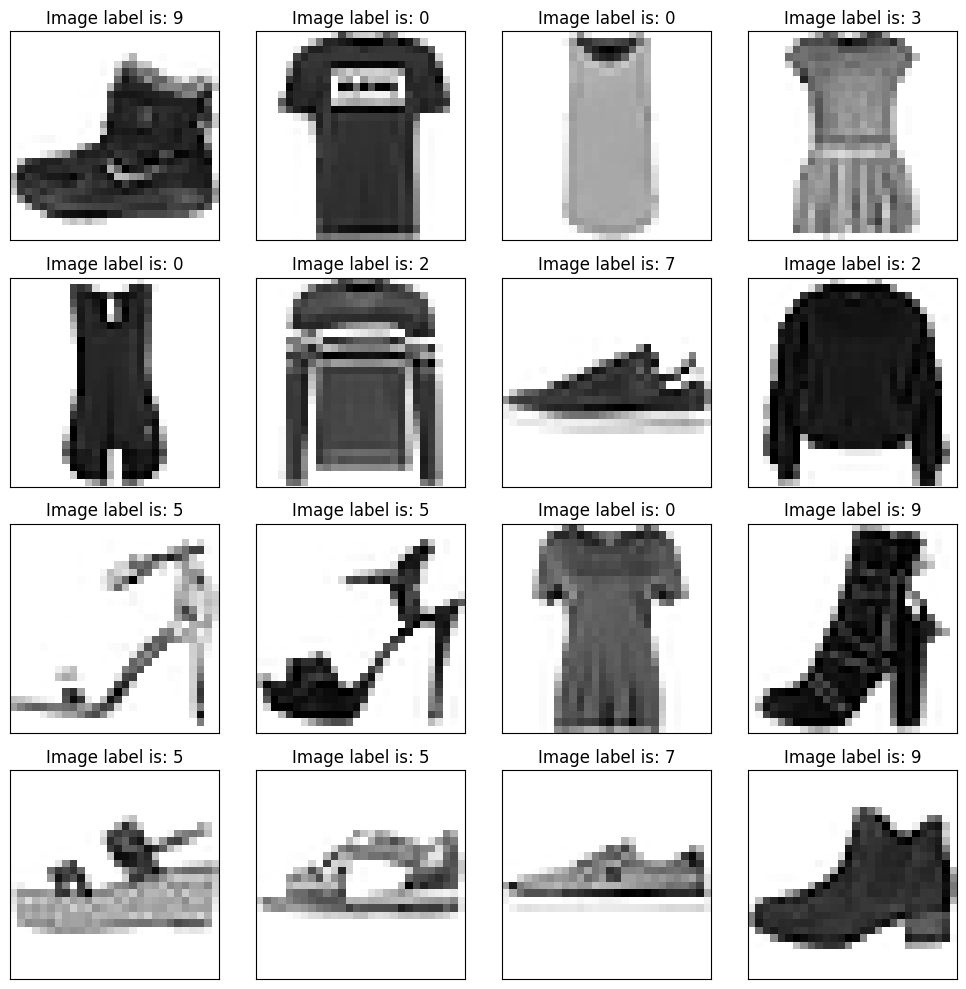

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_rows=4, num_cols=4, cmap='binary'):
    """Plot a grid of images with their labels."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    for i, ax in enumerate(axes):
        if i < len(images):
            # Display image
            ax.imshow(images[i], cmap=cmap)
            # Display label
            ax.set_title(f"Image label is: {labels[i]}")

        # Remove ticks and labels from axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()
    plt.show()

# Usage example with train_images and train_labels loaded from keras.datasets.fashion_mnist
plot_images(train_images, train_labels)


Ahora contamos las ocurrencias de cada etiqueta dentro del conjunto de entrenamiento  del dataset Fashion MNIST, y visualiza esta información en un gráfico de barras.

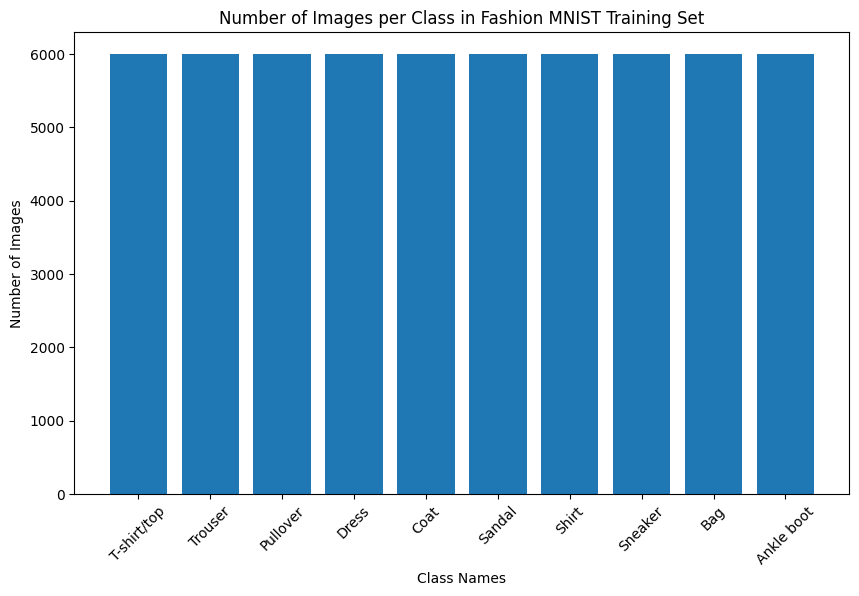

In [ ]:
import numpy as np
# Contar las ocurrencias de cada etiqueta en el conjunto de entrenamiento y de prueba
unique, counts = np.unique(train_labels, return_counts=True)
train_label_counts = dict(zip(unique, counts))

# Opcionalmente, también puedes contar las etiquetas en el conjunto de prueba:
# unique_test, counts_test = np.unique(test_labels, return_counts=True)
# test_label_counts = dict(zip(unique_test, counts_test))

# Nombres de las clases para etiquetas de 0 a 9
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(class_names, [train_label_counts[i] for i in unique])
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Fashion MNIST Training Set')
plt.xticks(rotation=45)
plt.show()

Existen 10 clases de prendas  y cada una presenta 6.000 imagenes en su set de entrenamiento, por lo tanto tenemos 60.000 imagenes.

In [ ]:
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))


El código  realiza una operación de cambio de forma en los dos conjuntos de datos de imágenes, train_images y test_images, que son comúnmente usados en tareas de procesamiento de imágenes.

Utilizaremos una capa personalizada en TensorFlow utilizando la API de Keras. Esta capa se llama **Sampler** y está diseñada específicamente para realizar el muestreo estocástico en una arquitectura de red neuronal de Autoencoder Variacional.

Este componente es crucial en un VAE porque permite que el modelo genere nuevas muestras a partir del espacio latente mientras mantiene la capacidad de calcular gradientes para el aprendizaje mediante retropropagación.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

Se define la entrada del modelo usando keras.Input. La forma (28, 28, 1) indica que el modelo espera imágenes de 28x28 píxeles con un solo canal de color.

Se utilizan dos capas convolucionales (Conv2D) con activaciones ReLU. Cada capa tiene un tamaño de kernel de 3x3 y un stride de 2, lo cual reduce progresivamente la dimensión espacial de las imágenes mientras aumenta la profundidad de los mapas de características. La opción padding="same" asegura que el tamaño de salida se mantenga ajustado al aplicar el kernel.

Tras las capas convolucionales, la salida se aplana en un vector largo único, y luego se conecta a una capa densa con 16 unidades y activación ReLU para procesamiento adicional.

La capa densa final se divide en dos partes distintas: una para las medias (z_mean) y otra para los logaritmos de las varianzas (z_log_var) del espacio latente. Estos parámetros son cruciales para la posterior generación y manipulación de datos en un VAE.

Finalmente, se define el modelo del codificador con keras.Model, especificando las entradas y las salidas. El modelo toma las imágenes de entrada y produce dos salidas: z_mean y z_log_var, que representan el espacio latente codificado.

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

Vamo a revertir las operaciones realizadas por el codificador que discutimos anteriormente.

El objetivo de este decodificador es transformar una representación latente (espacio comprimido) de vuelta a una imagen de alta dimensión (en este caso, imágenes de 28x28 píxeles).

Se define la entrada del decodificador que acepta datos en el espacio latente de dimensiones especificadas (latent_dim, que antes se estableció en 2). Esto corresponde a las salidas z_mean y z_log_var del codificador.

Se utiliza una capa densa que proyecta la entrada latente hacia una dimensión mayor (7 * 7 * 64), preparando el tamaño adecuado para comenzar el proceso de transposición convolucional. La activación ReLU se usa para añadir no linealidad.

Tras la capa densa, los datos se reestructuran a un formato tridimensional para simular el estado de las imágenes en una etapa intermedia del codificador (justo antes de que las imágenes fueran completamente aplanadas), preparándolos para las siguientes transposiciones convolucionales.

Estas capas utilizan la convolución transpuesta para aumentar gradualmente la resolución espacial de las entradas. Esencialmente, estas operaciones son el proceso inverso de las capas convolucionales en el codificador, reconstruyendo la imagen desde la representación comprimida. Las capas usan un stride de 2 para duplicar las dimensiones de las imágenes en cada paso.


La última capa es una convolución que transforma la salida a la forma deseada de la imagen original (28x28x1). La activación sigmoid se utiliza para normalizar la salida a un rango [0, 1], apropiado para imágenes en escala de grises.

Finalmente, se define el modelo del decodificador especificando las entradas y salidas. Este modelo toma una representación latente y produce una imagen reconstruida.

Ambos, codificador y decodificador, son componentes simétricos en un VAE, con el codificador transformando datos de alta dimensión en baja dimensión y el decodificador haciendo lo contrario, con el objetivo de aprender eficientemente una representación útil del espacio de datos.

In [ ]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
import numpy as np

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(train_images, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 201s 424ms/step - total_loss: 333.5263 - reconstruction_loss: 327.7415 - kl_loss: 5.7848
Epoch 2/30
469/469 [==============================] - 200s 426ms/step - total_loss: 280.9766 - reconstruction_loss: 275.4940 - kl_loss: 5.4827
Epoch 3/30
469/469 [==============================] - 184s 393ms/step - total_loss: 274.2546 - reconstruction_loss: 269.3990 - kl_loss: 4.8560
Epoch 4/30
469/469 [==============================] - 193s 411ms/step - total_loss: 271.2581 - reconstruction_loss: 266.6218 - kl_loss: 4.6363
Epoch 5/30
469/469 [==============================] - 196s 419ms/step - total_loss: 269.5294 - reconstruction_loss: 265.0298 - kl_loss: 4.4998
Epoch 6/30
469/469 [==============================] - 191s 407ms/step - total_loss: 268.1863 - reconstruction_loss: 263.7567 - kl_loss: 4.4298
Epoch 7/30
469/469 [==============================] - 194s 413ms/step - total_loss: 267.2554 - reconstruction_loss: 262.8933 - kl_loss: 4.3619

 El modelo VAE ha sido entrenado durante 30 épocas y ha logrado una pérdida total promedio de 259.3524 en la última época, con una pérdida de reconstrucción promedio de 255.3485 y una pérdida de divergencia de Kullback-Leibler (KL) promedio de 4.0042. Un valor bajo de pérdida total indica que el modelo está siendo efectivo en la reconstrucción de imágenes y en la captura de una buena distribución en el espacio latente.

Finalmente obtenemos la imgen:


Este código genera una cuadrícula de imágenes generadas por el decodificador de un modelo VAE, organizadas en una cuadrícula 2D de acuerdo a las posiciones de los puntos muestreados en el espacio latente.

n representa el número de dígitos en cada dimensión de la cuadrícula (30 en este caso), y digit_size representa el tamaño de cada dígito (28x28 píxeles en este caso, ya que se trata de imágenes de dígitos MNIST).


grid_x y grid_y -> Se muestrean puntos linealmente en una cuadrícula 2D, utilizando valores entre -1 y 1 para cada dimensión del espacio latente.

1/1 [==============================] - 0s 25ms/step


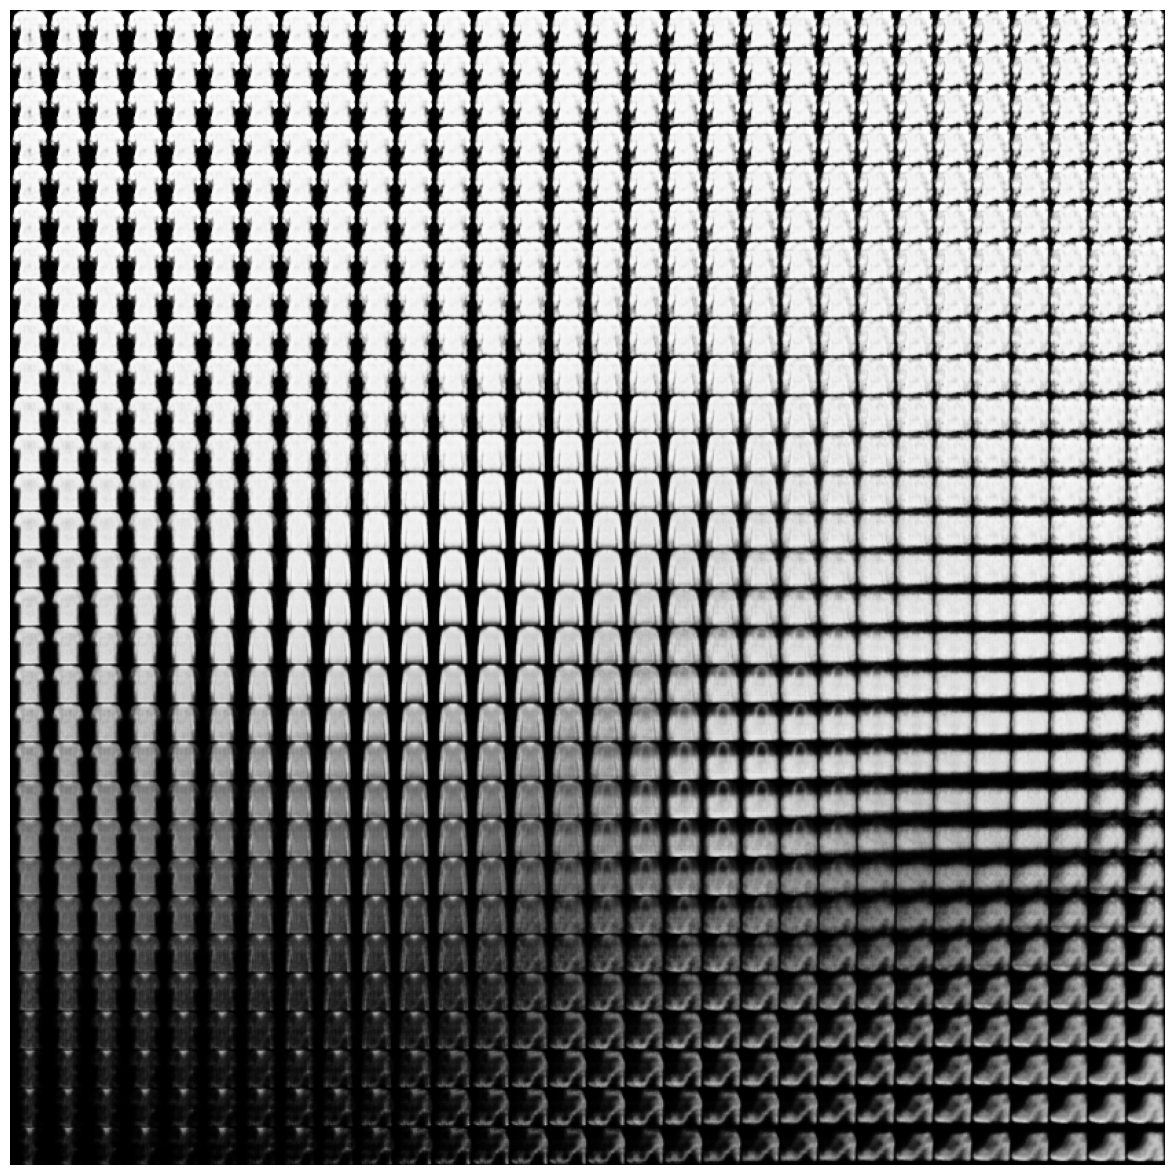

In [ ]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 30 × 30 dígitos (900 dígitos en total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

# **Ejercicio 2**

**Obteniendo los datos de UT-Zap50k**

Conjunto de datos: https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip

In [ ]:
# Creamos el directorio de trabajo
!mkdir utzap50k_gan

# Descargamos los datos comprimidos usando el enlace proporcionado
!wget https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip -P utzap50k_gan

# Descomprimimos los datos
!unzip -qq utzap50k_gan/ut-zap50k-images-square.zip -d utzap50k_gan

--2024-05-05 12:15:00--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘utzap50k_gan/ut-zap50k-images-square.zip’

ut-zap50k-images-sq 100%[===================>] 137.55M  55.6MB/s    in 2.5s    

2024-05-05 12:15:03 (55.6 MB/s) - ‘utzap50k_gan/ut-zap50k-images-square.zip’ saved [144233542/144233542]



**Creamos un dataset a partir de un directorio de imágenes**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "utzap50k_gan",
    # Solo se devolverán las imágenes, sin etiquetas.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # Cambiaremos el tamaño de las imágenes a 64 × 64
    # usando una combinación inteligente de recorte y
    # cambio de tamaño para preservar la relación de
    # aspecto. ¡No queremos que las proporciones se
    # distorsionen!
    smart_resize=True)

Found 50066 files belonging to 1 classes.


**Rescalamos las imágenes**

Aplicamos una transformación a cada elemento del dataset. En este caso específico,  contiene datos de imágenes, y la transformación está dividiendo cada valor de píxel en cada imagen por 255.

Por lo que normalizamos las imágenes. Dividir cada valor de píxel por 255 es una forma común de normalizar imágenes para que los valores estén en el rango de 0 a 1

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**Mostramos la primera imagen**

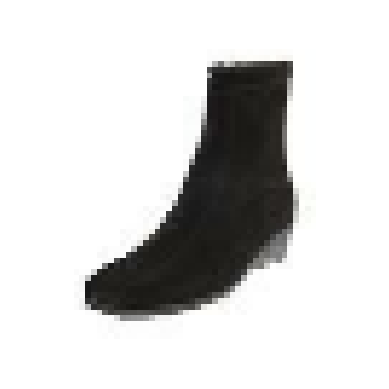

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## El Discriminador

**La red discriminadora (discriminator) GAN**

El código define un discriminador convolucional para una GAN, que toma imágenes de 64x64 píxeles como entrada y produce una sola salida que representa la probabilidad de que la imagen sea real.

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

Esta red utiliza el framework Keras y está diseñada para trabajar con imágenes de entrada de 64x64 píxeles con 3 canales (colores RGB).

**Resumen de las capas y configuraciones que se presentan en la imagen:**

- Capa de Entrada: Tamaño de entrada especificado de 64x64x3.


- Primera Capa Convolucional (Conv2D): 64 filtros con un tamaño de kernel de 4, strides de 2, y padding "same". Esta capa tiene 3.136 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Segunda Capa Convolucional (Conv2D): 128 filtros con un tamaño de kernel de 4, strides de 2, y padding "same". Esta capa tiene 131.200 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Tercera Capa Convolucional (Conv2D): 128 filtros con un tamaño de kernel de 4, strides de 2, y padding "same". Esta capa tiene 262.272 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Aplanamiento (Flatten): Convierte la matriz 3D de la última capa convolucional a un vector 1D. No tiene parámetros entrenables.
Dropout: Con un ratio de 0.2 para evitar el sobreajuste. Esta capa no tiene parámetros entrenables.


- Capa Densa (Dense): Una sola unidad con activación sigmoidal para la clasificación binaria. Esta capa tiene 8.193 parámetros.


En total, el modelo tiene 404.801 parámetros, todos entrenables.

## El Generador

**La Red Generadora GAN**

Definimos un generador para una GAN que toma vectores del espacio latente como entrada y produce imágenes sintéticas como salida.

In [ ]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

Esta red está configurada para generar imágenes a partir de un espacio latente de 128 dimensiones.


**Un resumen de las capas y configuraciones que se presentan en la imagen**:

- Capa de Entrada: Tamaño de entrada especificado como un vector de 128 dimensiones.


- Primera Capa Densa (Dense): Produce un total de 8192 coeficientes (8x8x128). Esta capa tiene 1.056.768 parámetros.


- Reshape: Reajusta la salida de la capa densa a una matriz 3D de 8x8x128. No tiene parámetros entrenables.


- Primera Capa Convolucional Transpuesta (Conv2DTranspose): 128 filtros, kernel de tamaño 4, strides de 2, y padding "same". Tiene 262.272 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Segunda Capa Convolucional Transpuesta (Conv2DTranspose): 256 filtros, kernel de tamaño 4, strides de 2, y padding "same". Tiene 524.544 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Tercera Capa Convolucional Transpuesta (Conv2DTranspose): 512 filtros, kernel de tamaño 4, strides de 2, y padding "same". Tiene 2.097.664 parámetros.


- Activación LeakyReLU: Con un valor alpha de 0.2. Esta capa no tiene parámetros entrenables.


- Capa Convolucional Final (Conv2D): 3 filtros (para los canales RGB), kernel de tamaño 5, y padding "same", con activación sigmoidal para producir valores de pixel entre 0 y 1. Tiene 38.403 parámetros.


El modelo tiene un total de 3.979.651 parámetros, todos ellos entrenables.

## La Red Antagónica (Adversarial)

**El `Model` GAN**

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**Una callback que muestra imágenes generadas durante el entrenamiento**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compilando y entrenando la GAN**

In [ ]:
epochs = 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/20
1565/1565 [==============================] - 417s 258ms/step - d_loss: 0.6228 - g_loss: 0.9568
Epoch 2/20
1565/1565 [==============================] - 403s 257ms/step - d_loss: 0.5993 - g_loss: 1.3278
Epoch 3/20
1565/1565 [==============================] - 402s 257ms/step - d_loss: 0.6534 - g_loss: 0.9549
Epoch 4/20
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6571 - g_loss: 0.9157
Epoch 5/20
1565/1565 [==============================] - 400s 256ms/step - d_loss: 0.6479 - g_loss: 0.9691
Epoch 6/20
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6635 - g_loss: 0.9392
Epoch 7/20
1565/1565 [==============================] - 400s 256ms/step - d_loss: 0.6491 - g_loss: 0.9477
Epoch 8/20
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6538 - g_loss: 0.9519
Epoch 9/20
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6566 - g_loss: 0.9630
Epoch 10/20
1565/1565 [=======================

Se observa el progreso del modelo GANS construido para esta base de datos a la largo de 20 epochs. En el modelo visto en clase, se entrenó con 100 épocas pero debido al tiempo de ejecución por época y a que el entorno de ejecución a partir de la época 20 se desconectaba su entorno de ejecución, llegamos a la conclusión de que lo mejor era entrenar el modelo con una 20 épocas.

De los resultados se puede observar  que para cada época, se presentan las pérdidas del discriminador y del generador, etiquetadas como d_loss y g_loss, respectivamente.

Al inicio, la pérdida del discriminador (d_loss) se encuentra alrededor de 0.62. Aunque fluctúa un poco durante las épocas, tiende a disminuir de manera general hasta ubicarse cerca de 0.66 al final de la última época.

En cambio, la pérdida del generador (g_loss) empieza en un valor alto, cercano a 1.32, y disminuye gradualmente con el tiempo, alcanzando aproximadamente 0.88 al final.

Este comportamiento sugiere que, si bien las pérdidas del discriminador se mantienen relativamente estables (aquello que si el rendimiento es consistente al distinguir imágenes falsas de las reales), la pérdida del generador disminuye gradualmente, indicando que está aprendiendo a crear imágenes cada vez más convincentes para engañar al discriminador.

En resumen, la reducción progresiva de la pérdida del generador demuestra que mejora en su capacidad de generar imágenes realistas a lo largo de las épocas de entrenamiento. Al mismo tiempo, la estabilidad de la pérdida del discriminador muestra que se mantiene preciso al identificar las imágenes generadas. Estos resultados indican un proceso de entrenamiento exitoso para la GAN. Sin embargo, para tener una valoración completa, sería necesario realizar una evaluación más detallada, incluyendo la calidad de las imágenes generadas.








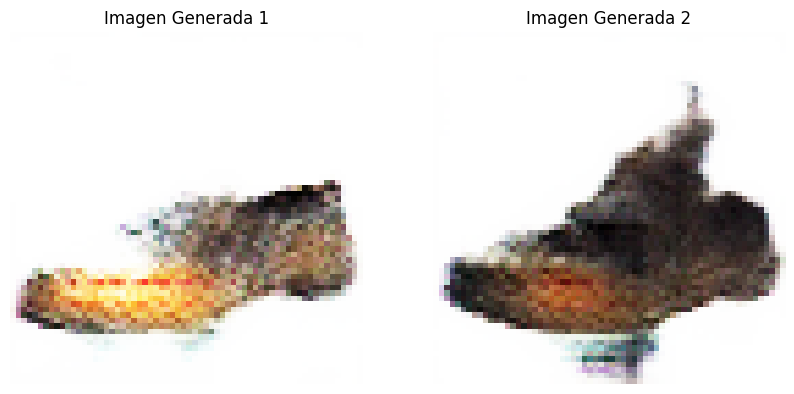

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Ruta de las imágenes generadas en la última época
img1_path = "generated_img_{:03d}_0.png".format(epochs - 1)
img2_path = "generated_img_{:03d}_1.png".format(epochs - 1)

# Carga las imágenes usando PIL
img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

# Crea una figura de matplotlib y muestra las imágenes
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Imagen Generada 1')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Imagen Generada 2')

plt.show()



Las imágenes generadas muestran que la GAN es capaz de crear representaciones básicas de los objetos en la época 19.

Sin embargo, los detalles aún son pixelados entorno a dicha época por lo que una mejora sería proceder a aumentar el número de épocas para tener un mejora y más preciso entrenamiento o realizar ajustes en la arquitectura o parámetros para mejorar la calidad de las imágenes.